In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -r requirements.txt
!pip install -U sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Ignoring tensorflow-macos: markers 'sys_platform == "darwin" and "ARM" in platform_version' don't match your environment
Ignoring tensorflow: markers 'sys_platform == "darwin" and "ARM" not in platform_version' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 KB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from transformers import  TFDebertaV2Model, DebertaV2TokenizerFast
from tensorflow.keras import callbacks
from tensorflow.keras import layers, Input, Sequential, Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from enum import auto

In [ ]:
!mkdir -p /content/drive/MyDrive/mathieu_deberta_v2_xlarge_model_batch_16_third_test


In [ ]:
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

In [ ]:
class config:
    base_dir = "/kaggle/working/"
  
    # dataset path   
    train_dataset_path='/content/train.csv'
    test_dataset_path = '/content/test.csv'
    
    #tokenizer params
    truncation = True
    padding = True #'max_length'
    max_length = 512
    
    # model params
    train_col='full_text'
    model_name = "microsoft/deberta-v2-xlarge"
    target_cols = ['cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions']

In [ ]:
tokenizer = DebertaV2TokenizerFast.from_pretrained("microsoft/deberta-v2-xlarge")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def tokenize (df):
    texts=list(df[config.train_col])
    tokenized=tokenizer(texts,
                       padding=config.padding,
                       truncating=True,
                       max_length=config.max_length)
    tokenized["labels"]= [df[column] for column in config.target_cols]
    tokenized['length'] = len(tokenized['input_ids'])
    
    return tokenized

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/raw_data + requirements/train.csv').copy()
texts=data[config.train_col]
targets=data[config.target_cols]
train_texts, val_texts, train_targets, val_targets=train_test_split(texts, targets, test_size=0.3)

In [ ]:
data_test_texts = pd.read_csv('/content/drive/MyDrive/raw_data + requirements/test.csv').copy()
test_texts = data_test_texts[config.train_col]

In [ ]:
tokenized_train_texts = tokenizer(list(train_texts), return_tensors='tf',truncation=config.truncation, padding=config.padding)
tokenized_val_texts = tokenizer(list(val_texts), return_tensors='tf', truncation=config.truncation, padding=config.padding)
tokenized_test_texts = tokenizer(list(test_texts), return_tensors='tf', truncation=config.truncation, padding=config.padding)

In [ ]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [ ]:
input_ids = Input(shape=((512)),dtype='int32')

In [ ]:
# Import the needed model(Bert, Roberta or DistilBert) with output_hidden_states=True
transformer_model = TFDebertaV2Model.from_pretrained('microsoft/deberta-v2-xlarge', output_hidden_states=True, return_dict=True)
transformer_model.trainable = False

input_ids = Input(shape=((512)),dtype='int32', name='input_ids')
attention_mask = Input(shape=((512)), dtype='int32', name='attention_mask')

transformer = transformer_model(dict(input_ids=input_ids,attention_mask=attention_mask))    
hidden_states = transformer[0] # get output_hidden_states


# Add a layer Maxpool 1D
pooling_layer = layers.GlobalMaxPooling1D()(hidden_states)

# Now we can use selected_hiddes_states as we want
last_hidden_layer = layers.Dense(128, activation='relu')(pooling_layer)

# Defining the regression layer
cohesion_output=layers.Dense(1, activation="linear", name="cohesion")(last_hidden_layer)
syntax_output=layers.Dense(1, activation="linear", name="syntax")(last_hidden_layer)
vocabulary_output=layers.Dense(1, activation="linear", name="vocabulary")(last_hidden_layer)
phraseology_output=layers.Dense(1, activation="linear", name="phraseology")(last_hidden_layer)
grammar_output=layers.Dense(1, activation="linear", name="grammar")(last_hidden_layer)
conventions_output=layers.Dense(1, activation="linear", name="conventions")(last_hidden_layer)

# output in a list
output= [cohesion_output, syntax_output, vocabulary_output, phraseology_output, grammar_output, conventions_output]

#Assembling the model
model = Model(inputs = [input_ids, attention_mask], outputs = output)
model.summary()

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v2-xlarge.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_deberta_v2_model (TFDeberta  TFBaseModelOutput(l  884593152  ['attention_mask[0][0]',         
 V2Model)                       ast_hidden_state=(N               'input_ids[0][0]']              
                                one, 512, 1536),                                                  
                                 hidden_states=((No                                           

In [ ]:
# Compile the model 
model.compile(loss='mse', optimizer='adam',loss_weights=[1/6 for i in range(6)], metrics= root_mean_squared_error)

In [19]:
# Fit the model
es = callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001,cooldown=2, mode=auto)

checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, save_freq='epoch', mode=min)

callbacks_list = [es,reduce_lr,checkpoint]

history = model.fit(x={'input_ids':tokenized_train_texts['input_ids'],
                        'attention_mask':tokenized_train_texts['attention_mask']},
                    y=train_targets,epochs=100,batch_size=16,validation_split=0.2, callbacks=callbacks_list,verbose=1)

Epoch 1/100


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


137/137 [==============================] - ETA: 0s - loss: 1.0709 - cohesion_loss: 1.5300 - syntax_loss: 0.6255 - vocabulary_loss: 1.0319 - phraseology_loss: 1.4926 - grammar_loss: 0.7730 - conventions_loss: 0.9724 - cohesion_root_mean_squared_error: 0.8658 - syntax_root_mean_squared_error: 0.6814 - vocabulary_root_mean_squared_error: 0.7806 - phraseology_root_mean_squared_error: 0.8735 - grammar_root_mean_squared_error: 0.7512 - conventions_root_mean_squared_error: 0.7890
Epoch 1: val_loss improved from inf to 0.47082, saving model to my_best_model.epoch01-loss0.47.hdf5
137/137 [==============================] - 624s 4s/step - loss: 1.0709 - cohesion_loss: 1.5300 - syntax_loss: 0.6255 - vocabulary_loss: 1.0319 - phraseology_loss: 1.4926 - grammar_loss: 0.7730 - conventions_loss: 0.9724 - cohesion_root_mean_squared_error: 0.8658 - syntax_root_mean_squared_error: 0.6814 - vocabulary_root_mean_squared_error: 0.7806 - phraseology_root_mean_squared_error: 0.8735 - grammar_root_mean_squared

In [20]:
# Save the model weigths on google drive
model.save_weights('/content/drive/MyDrive/mathieu_deberta_v2_xlarge_model_batch_16_third_test/deberta_v2_xlarge_model_batch_16_third_test_weights.h5')

In [21]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history)

In [24]:
# Save to CSV
hist_csv_file = 'deberta_v2_xlarge_batch_16_third_test_history.csv'
with open(hist_csv_file, mode='w') as deberta_v2_xlarge_batch_4_third_test_history:
    hist_df.to_csv(deberta_v2_xlarge_batch_4_third_test_history)

In [26]:
# Load History df
hist_df = pd.read_csv(r'/content/drive/MyDrive/mathieu_deberta_v2_xlarge_model_batch_16_third_test/deberta_v2_xlarge_batch_16_third_test_history.csv')
print(hist_df)

    Unnamed: 0      loss  cohesion_loss  syntax_loss  vocabulary_loss  \
0            0  1.070910       1.530038     0.625484         1.031871   
1            1  0.464593       0.447259     0.463272         0.452261   
2            2  0.407936       0.377225     0.414183         0.416237   
3            3  0.360865       0.333237     0.371195         0.361918   
4            4  0.373349       0.318133     0.394880         0.374791   
..         ...       ...            ...          ...              ...   
95          95  0.266500       0.266094     0.262313         0.266456   
96          96  0.263768       0.264438     0.264310         0.261562   
97          97  0.266235       0.264539     0.264123         0.262868   
98          98  0.266925       0.265010     0.262730         0.267059   
99          99  0.265658       0.266858     0.259974         0.267911   

    phraseology_loss  grammar_loss  conventions_loss  \
0           1.492635      0.772991          0.972438   
1          

In [27]:
 # Make predictions on the test set
test_predictions = model.predict({'input_ids':tokenized_test_texts['input_ids'], 'attention_mask':tokenized_test_texts['attention_mask']})

# Create a list of dictionaries with the predictions
predictions_list = []
for i in range(len(test_predictions[0])):
    prediction_dict = {'cohesion': test_predictions[0][i],
                       'syntax': test_predictions[1][i],
                       'vocabulary': test_predictions[2][i],
                       'phraseology': test_predictions[3][i],
                       'grammar': test_predictions[4][i],
                       'conventions': test_predictions[5][i]}
    predictions_list.append(prediction_dict)

# Convert the list to a dataframe
predictions_df = pd.DataFrame(predictions_list)

1/1 [==============================] - 12s 12s/step


In [28]:
# Save the dataframe to a CSV file
predictions_df.to_csv('predictions_batch_16_third_test.csv', index=False)

In [29]:
# Display the predictions 
predictions_df

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,[2.7793517],[2.7308972],[2.4749029],[2.5623996],[2.5037456],[2.3332062]
1,[2.5565083],[2.1852205],[2.3468852],[2.396272],[2.2390304],[2.4921985]
2,[3.301841],[3.1267107],[3.5508475],[3.3705094],[3.3272362],[3.1321583]


In [30]:
# Model evaluation
model_eval = model.evaluate(x={'input_ids':tokenized_val_texts['input_ids'], 'attention_mask':tokenized_val_texts['attention_mask']},
                            y = val_targets)

37/37 [==============================] - 39s 1s/step - loss: 0.2647 - cohesion_loss: 0.2659 - syntax_loss: 0.2628 - vocabulary_loss: 0.2593 - phraseology_loss: 0.2649 - grammar_loss: 0.2658 - conventions_loss: 0.2692 - cohesion_root_mean_squared_error: 0.4815 - syntax_root_mean_squared_error: 0.4787 - vocabulary_root_mean_squared_error: 0.4760 - phraseology_root_mean_squared_error: 0.4812 - grammar_root_mean_squared_error: 0.4809 - conventions_root_mean_squared_error: 0.4852


In [31]:
# Display Model evaluation
model_eval

[0.26467305421829224,
 0.26594507694244385,
 0.2627706527709961,
 0.2593338191509247,
 0.2649137079715729,
 0.2658385932445526,
 0.2692364454269409,
 0.4815443456172943,
 0.47870954871177673,
 0.4759867191314697,
 0.481239378452301,
 0.4809137284755707,
 0.48518118262290955]

In [37]:
# Convert to a dataframe
eval_df = pd.DataFrame(model_eval)

In [38]:
# Save the dataframe to a CSV file
eval_df.to_csv('predictions_batch_4_dynamic_lr.csv', index=False)

In [34]:
# Mean score 
mean_score = np.mean(model_eval[-6:])
mean_score

0.48059581716855365

In [35]:
# Dataviz
def plot_history(history, title='', axs=None, exp_name=""):

    #compute new metrics and add in 'history.history'
    metrics=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    scores=['loss','root_mean_squared_error']
    history.history['MCRMSE']=[]
    history.history['val_MCRMSE']=[]
    for epoch in range(len(history.history['loss'])):
      mcrmse=0
      val_mcrmse=0
      for m in metrics:
        mcrmse +=history.history[f'{m}_root_mean_squared_error'][epoch]
        val_mcrmse +=history.history[f'val_{m}_root_mean_squared_error'][epoch]
      history.history['MCRMSE'].append(mcrmse/len(metrics))
      history.history['val_MCRMSE'].append(val_mcrmse/len(metrics))

    if axs is not None:
        ax1, ax2 = axs
    else:
        f, ax = plt.subplots(7, 2, figsize=(12, 2*7))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name

    ax[0][0].plot(history.history['loss'], label='train' + exp_name)
    ax[0][0].plot(history.history['val_loss'], label='val' + exp_name)
    ax[0][0].set_title('loss')
    ax[0][0].legend()
   
    ax[0][1].plot(history.history['MCRMSE'], label='train' + exp_name)
    ax[0][1].plot(history.history['val_MCRMSE'], label='val' + exp_name)
    ax[0][1].set_title('MCRMSE')
    ax[0][1].legend()
    i=0
    for m in metrics:
      j=0
      i+=1
      for s in scores:
        ax[i][j].plot(history.history[f'{m}_{s}'], label='train' + exp_name)
        ax[i][j].plot(history.history[f'val_{m}_{s}'], label='val' + exp_name)
        ax[i][j].set_title(f'{m}_{s}')
        ax[i][j].legend()
        j+=1
        
    return ax

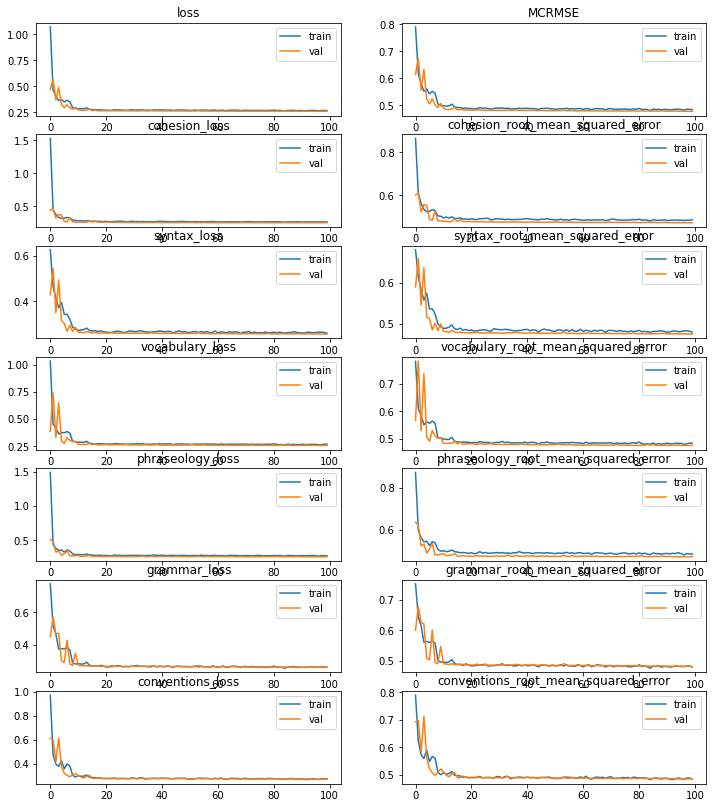

In [36]:
# Plot history viz
plot_history(history);